# EDA Precios de Vivienda

Exploramos `fact_precios` para entender la cobertura temporal, fuentes y variaciones por territorio.

## Objetivos
- Resumir fuentes disponibles (Open Data BCN vs Portal de Dades).
- Analizar series temporales de venta y alquiler.
- Detectar outliers o datos faltantes que requieran limpieza adicional.



In [5]:
from pathlib import Path
import sqlite3

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

PROJECT_ROOT = Path.cwd().resolve().parent
DB_PATH = PROJECT_ROOT / "data" / "processed" / "database.db"

pd.set_option("display.float_format", lambda v: f"{v:,.2f}")
pd.set_option("display.max_columns", 30)

sns.set_theme(style="whitegrid")
print(f"Usando base de datos: {DB_PATH}")


Usando base de datos: /Users/adrianiraeguialvear/Projects/barcelona-housing-demographics-analyzer/data/processed/database.db


In [6]:
def load_table(table_name: str) -> pd.DataFrame:
    with sqlite3.connect(DB_PATH) as conn:
        df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
    print(f"{table_name}: {len(df):,} filas")
    return df


dim_barrios = load_table("dim_barrios")
fact_precios = load_table("fact_precios")


dim_barrios: 73 filas
fact_precios: 9,682 filas


In [7]:
metrics = ["precio_m2_venta", "precio_mes_alquiler"]


In [8]:
fact_precios.head()


,id,barrio_id,anio,periodo,trimestre,precio_m2_venta,precio_mes_alquiler,dataset_id,source,etl_loaded_at
0,2416,1,2012,2012,None,"2,265.62",NaN,mrslyp5pcq,portaldades,2025-11-13T14:47:46.276575
1,2417,1,2012,2012,None,"1,816.11",NaN,bxtvnxvukh,portaldades,2025-11-13T14:47:46.276575
2,2418,1,2012,2012,None,"2,224.82",NaN,idjhkx1ruj,portaldades,2025-11-13T14:47:46.276575
3,2419,1,2012,2012,None,"164,664.25",NaN,hostlmjrdo,portaldades,2025-11-13T14:47:46.276575
4,2420,2,2012,2012,None,"1,846.88",NaN,mrslyp5pcq,portaldades,2025-11-13T14:47:46.276575


In [9]:
fact_precios[metrics].isna().sum().to_frame(name="nulls")


,nulls
precio_m2_venta,1688
precio_mes_alquiler,7994


In [10]:
fact_precios.groupby(["source", "dataset_id"]).size().sort_values(ascending=False).head(20)


source                 dataset_id       
portaldades            mrslyp5pcq           968
                       bxtvnxvukh           963
                       hostlmjrdo           963
                       idjhkx1ruj           947
                       b37xv8wcjh           845
                       5ibudgqbrb           843
                       la6s9fp57r           837
                       u25rr7oxh6           836
                       9ap8lewvtt           834
                       cq4causxvu           834
                       bhl3ulphi5           753
opendatabcn_idealista  habitatges-2na-ma     59
dtype: int64

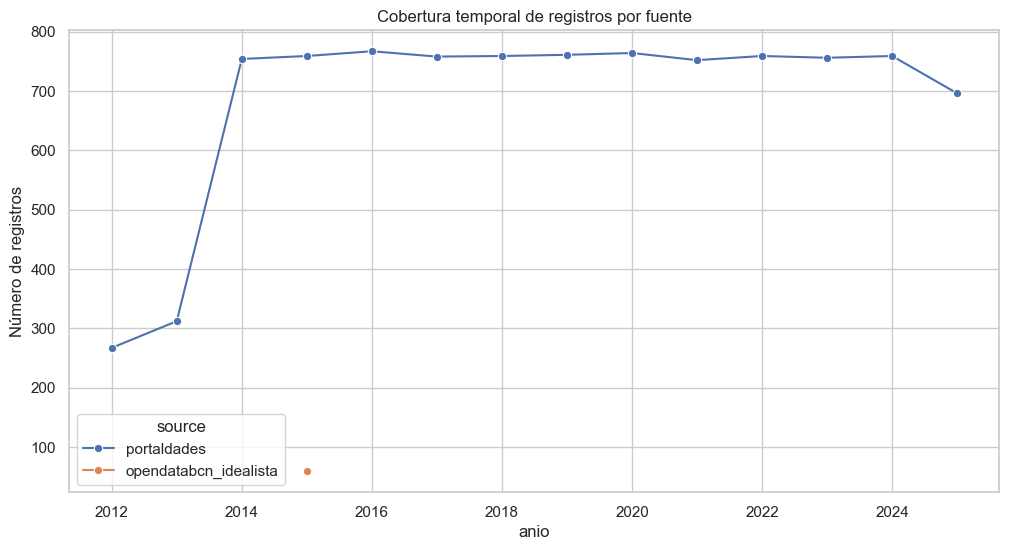

In [11]:
cobertura = fact_precios.groupby(["anio", "source"]).size().reset_index(name="registros")
plt.figure(figsize=(12, 6))
sns.lineplot(data=cobertura, x="anio", y="registros", hue="source", marker="o")
plt.title("Cobertura temporal de registros por fuente")
plt.ylabel("Número de registros")
plt.show()


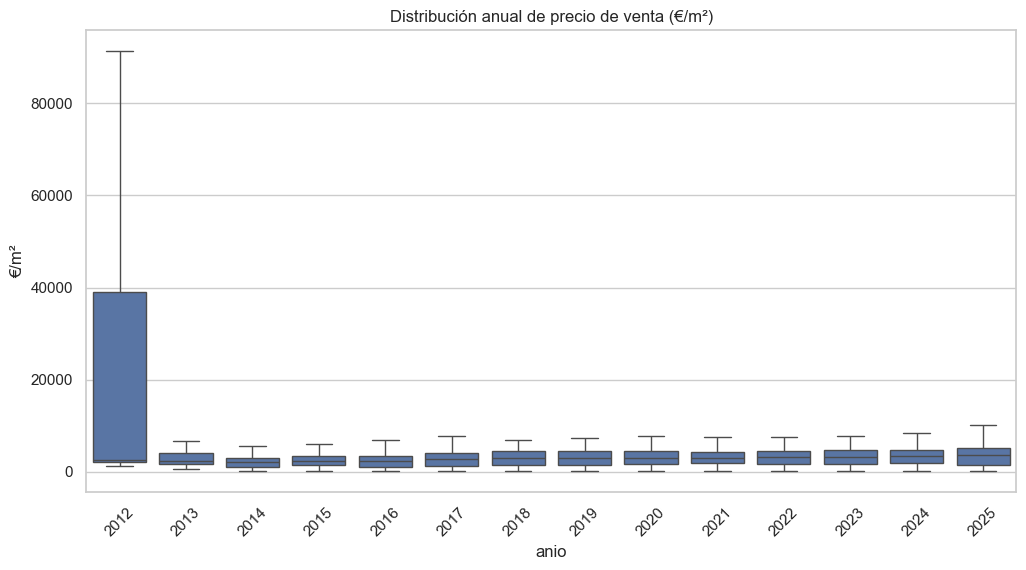

In [12]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=fact_precios,
    x="anio",
    y="precio_m2_venta",
    showfliers=False
)
plt.xticks(rotation=45)
plt.title("Distribución anual de precio de venta (€/m²)")
plt.ylabel("€/m²")
plt.show()


/var/folders/8t/1rzjlj6n3rj3v08skl2pwjbm0000gn/T/ipykernel_53837/465158021.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")


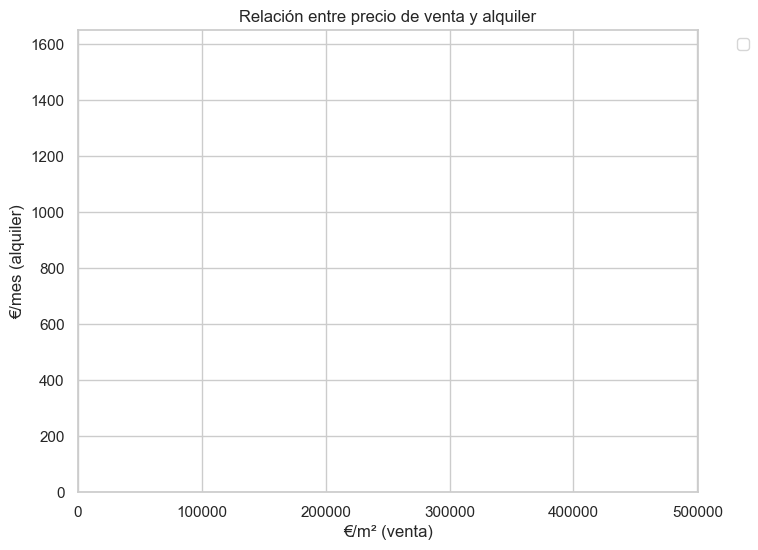

In [13]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=fact_precios,
    x="precio_m2_venta",
    y="precio_mes_alquiler",
    hue="source",
    alpha=0.5
)
plt.xlim(0, fact_precios["precio_m2_venta"].quantile(0.99))
plt.ylim(0, fact_precios["precio_mes_alquiler"].quantile(0.99))
plt.title("Relación entre precio de venta y alquiler")
plt.xlabel("€/m² (venta)")
plt.ylabel("€/mes (alquiler)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


In [14]:
ultimo_anio = fact_precios["anio"].max()
precios_latest = fact_precios[fact_precios["anio"] == ultimo_anio]
precios_latest = precios_latest.merge(
    dim_barrios[["barrio_id", "barrio_nombre", "distrito_nombre"]],
    on="barrio_id",
    how="left"
)
precios_latest.sort_values("precio_m2_venta", ascending=False).head(10)[[
    "barrio_nombre", "distrito_nombre", "precio_m2_venta", "precio_mes_alquiler", "source"
]]


,barrio_nombre,distrito_nombre,precio_m2_venta,precio_mes_alquiler,source
216,les Tres Torres,Sarrià-Sant Gervasi,"1,269,046.47",NaN,portaldades
186,Pedralbes,Les Corts,"1,078,442.41",NaN,portaldades
236,Sant Gervasi - Galvany,Sarrià-Sant Gervasi,"891,075.85",NaN,portaldades
206,Sarrià,Sarrià-Sant Gervasi,"831,046.45",NaN,portaldades
66,la Dreta de l'Eixample,Eixample,"796,123.68",NaN,portaldades
226,Sant Gervasi - la Bonanova,Sarrià-Sant Gervasi,"715,530.54",NaN,portaldades
246,el Putxet i el Farró,Sarrià-Sant Gervasi,"642,131.92",NaN,portaldades
652,Diagonal Mar i el Front Marítim del Poblenou,Sant Martí,"569,521.14",NaN,portaldades
76,l'Antiga Esquerra de l'Eixample,Eixample,"557,045.37",NaN,portaldades
396,la Clota,Horta-Guinardó,"542,036.43",NaN,portaldades


## Observaciones a completar

- Destacar barrios con precios extremos y validar si corresponden a datasets específicos.
- Analizar los periodos sin datos de alquiler (fuentes vacías).
- Generar mapas/cloropletas con los resultados y comparar con indicadores demográficos.



In [15]:
metrics = ["precio_m2_venta", "precio_mes_alquiler"]
fact_precios[metrics].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])


,precio_m2_venta,precio_mes_alquiler
count,"7,994.00","1,688.00"
mean,"32,650.36",438.07
std,"99,761.62",470.95
min,44.00,3.18
5%,165.62,8.96
25%,"1,501.96",12.63
50%,"2,793.21",213.88
75%,"4,310.38",816.67
95%,"227,697.47","1,223.61"
max,"1,269,046.47","2,088.15"
